# Predicting temperature time-series with the DeepAR built-in algorithm on Amazon SageMaker

http://berkeleyearth.org/data/

The data set we're going to work with holds a daily temperature measure from 1880 to 2014: http://berkeleyearth.lbl.gov/auto/Global/Complete_TAVG_daily.txt

Temperatures are reported as a delta from the 1951-1980 average (8.68°C).

## Download and pre-process data set

In [1]:
!wget http://berkeleyearth.lbl.gov/auto/Global/Complete_TAVG_daily.txt

# Remove header lines (starting with a %), empty lines and lines with only spaces
!grep -v -e '^%\|^$\|^\ *$' Complete_TAVG_daily.txt > temps.txt
!head -10 temps.txt

--2018-01-31 14:29:43--  http://berkeleyearth.lbl.gov/auto/Global/Complete_TAVG_daily.txt
Resolving berkeleyearth.lbl.gov (berkeleyearth.lbl.gov)... 128.3.29.26
Connecting to berkeleyearth.lbl.gov (berkeleyearth.lbl.gov)|128.3.29.26|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2614107 (2.5M) [text/plain]
Saving to: ‘Complete_TAVG_daily.txt.6’

Complete_TAVG_daily 100%[===================>]   2.49M  2.61MB/s    in 1.0s    

2018-01-31 14:29:44 (2.61 MB/s) - ‘Complete_TAVG_daily.txt.6’ saved [2614107/2614107]

1880.001     1880     1     1        1      -0.808
1880.004     1880     1     2        2      -0.670
1880.007     1880     1     3        3      -0.740
1880.010     1880     1     4        4      -0.705
1880.012     1880     1     5        5      -0.752
1880.015     1880     1     6        6      -0.810
1880.018     1880     1     7        7      -0.710
1880.021     1880     1     8        8      -0.767
1880.023     1880     1     9        9      -1.029

In [2]:
minYear  = 1880
maxYear  = 2014
avg_temp = 8.68

# Our model will predict temperature for the next 'prediction_length' days
prediction_length = 30

In [3]:
import csv, boto3, json, sagemaker
import numpy as np

In [57]:
f = open('temps.txt', 'r')
data = csv.reader(f,delimiter=' ')

dataset={}
x=[]
y=[]
count=1
prevYear=0

for row in data:
        # Remove empty strings caused by multiple spaces between columns
        row = filter(None, row)
        
        year=row[1]
        temp=float(row[5])+avg_temp
         
        # Data for plotting
        # x list=counter, y list=temperature
        x.append(count)
        y.append(float(temp))
        count=count+1
        
        # Data for training
        # dictionary: key=year, value=list of ordered daily temperatures
        if (year != prevYear):
            dataset[year]=[]
            prevYear=year
        dataset[year].append(float(temp))

[365 366]


In [60]:
nb_samples_per_year = list(map(lambda x: len(x), (dataset[str(year)] for year in range(minYear, maxYear+1))))
nb_samples_per_year = np.unique(nb_samples_per_year).tolist()
assert nb_samples_per_year == [365, 366]

## Plot data set

Number of samples: 49308


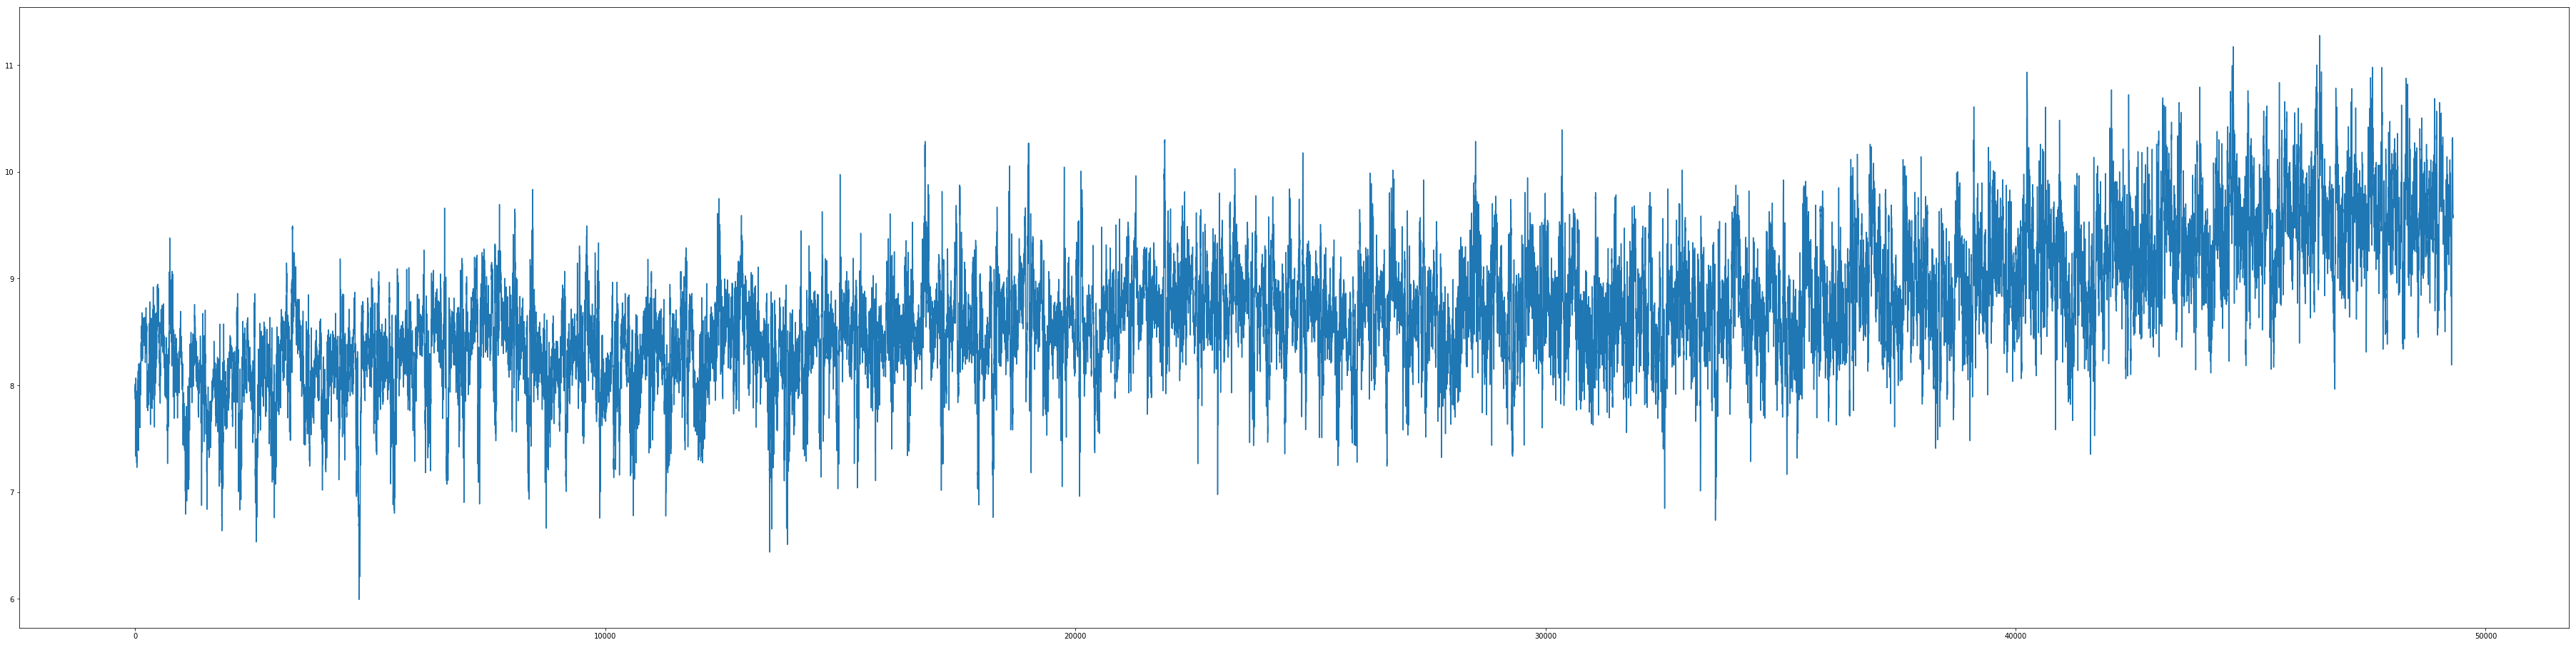

In [33]:
import matplotlib.pyplot as plt

nbSamples=len(x)
print('Number of samples: %d' % nbSamples)

fig=plt.figure(figsize=(64, 16))
plt.plot(x,y)
plt.show()

## Prepare training set and test set

In [47]:
# According to https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html
# - remove the last 'prediction_length' points from each time series
# - use the full data set for testing
# - no need to shuffle the training set: dictionaries are not ordered :)

trainingSet = dataset.copy()
trainingSet[year] = { year: dataset[year][:-prediction_length] for year in dataset.keys() }
testSet = dataset.copy()

335


In [8]:
def writeDataset(filename, data): 
    file=open(filename,'w')
    for year in data.keys():
        # One JSON sample per line
        line = "\"start\":\"{}-01-01 00:00:00\",\"target\":{}".format(year,data[year])
        file.write('{'+line+'}\n')

writeDataset(train_key, trainingSet)        
writeDataset(test_key, testSet)

In [9]:
#!head -1 deepar_training.json

## Upload training set and test set to S3

In [6]:
bucket         = 'jsimon-sagemaker-us'
prefix         = 'sagemaker/deepar-daily-temperature'

train_key      = 'deepar_training.json'
test_key       = 'deepar_test.json'
train_prefix   = '{}/{}'.format(prefix, 'train')
test_prefix    = '{}/{}'.format(prefix, 'test')
output_prefix  = '{}/{}'.format(prefix, 'output')

In [10]:
sagemaker_session = sagemaker.Session()
role              = sagemaker.get_execution_role()
region            = boto3.Session().region_name

train_path  = sagemaker_session.upload_data(train_key, bucket=bucket, key_prefix=train_prefix)
test_path   = sagemaker_session.upload_data(test_key,  bucket=bucket, key_prefix=test_prefix)
output_path = 's3://{}/{}'.format(bucket, output_prefix)

print(train_path)
print(test_path)
print(output_path)

s3://jsimon-sagemaker-us/sagemaker/deepar-daily-temperature/train/deepar_training.json
s3://jsimon-sagemaker-us/sagemaker/deepar-daily-temperature/test/deepar_test.json
s3://jsimon-sagemaker-us/sagemaker/deepar-daily-temperature/output


## Configure training job

In [11]:
containers = {
    'us-east-1': '522234722520.dkr.ecr.us-east-1.amazonaws.com/forecasting-deepar:latest',
    'us-east-2': '566113047672.dkr.ecr.us-east-2.amazonaws.com/forecasting-deepar:latest',
    'us-west-2': '156387875391.dkr.ecr.us-west-2.amazonaws.com/forecasting-deepar:latest',
    'eu-west-1': '224300973850.dkr.ecr.eu-west-1.amazonaws.com/forecasting-deepar:latest'
}

image_name = containers[region]

In [12]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.8xlarge',
    base_job_name='daily-temperature',
    output_path=output_path
)

In [61]:
# https://docs.aws.amazon.com/sagemaker/latest/dg/deepar_hyperparameters.html

hyperparameters = {
    "time_freq": 'D', # daily series
    "context_length": prediction_length,
    "prediction_length": prediction_length, # number of data points to predict
    "num_cells": "40",
    "num_layers": "2",
    "likelihood": "gaussian",
    "epochs": "250",
    "mini_batch_size": "32",
    "learning_rate": "0.00001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "10" # stop if loss hasn't improved in 10 epochs
}

estimator.set_hyperparameters(**hyperparameters)

## Run training job

In [62]:
print(train_path)
print(test_path)
print(output_path)

data_channels = {"train": train_path, "test": test_path}

s3://jsimon-sagemaker-us/sagemaker/deepar-daily-temperature/train/deepar_training.json
s3://jsimon-sagemaker-us/sagemaker/deepar-daily-temperature/test/deepar_test.json
s3://jsimon-sagemaker-us/sagemaker/deepar-daily-temperature/output


In [ ]:
%%time

estimator.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: daily-temperature-2018-01-31-22-07-07-547


...........................................................................
Arguments: train
[01/31/2018 22:13:16 INFO 140078416930624] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'dropout_rate': u'0.05', u'cardinality': u'', u'test_quantiles': u'[0.5, 0.9]', u'_num_gpus': u'auto', u'learning_rate': u'0.001', u'_kvstore': u'auto', u'num_layers': u'3', u'embedding_dimension': u'', u'num_cells': u'40', u'_num_kv_servers': u'auto', u'mini_batch_size': u'32', u'likelihood': u'gaussian', u'early_stopping_patience': u''}
[01/31/2018 22:13:16 INFO 140078416930624] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'dropout_rate': u'0.05', u'learning_rate': u'0.00001', u'num_cells': u'40', u'prediction_length': u'30', u'epochs': u'250', u'time_freq': u'D', u'context_length': u'30', u'num_layers': u'2', u'mini_batch_size': u'32', u'likelihood': u'gaussian', u'early_stopping_patience': u'10'}
[01/31/2018

[01/31/2018 22:13:29 INFO 140078416930624] Epoch[5] Batch[10] avg_epoch_loss=6.000475
[01/31/2018 22:13:29 INFO 140078416930624] Epoch[5] Batch [10]#011Speed: 281.62 samples/sec#011loss=6.009944
[01/31/2018 22:13:30 INFO 140078416930624] processed a total of 480 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1895.6708908081055, "sum": 1895.6708908081055, "min": 1895.6708908081055}}, "EndTime": 1517436810.488348, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1517436808.576929}

[01/31/2018 22:13:30 INFO 140078416930624] best epoch loss so far
[01/31/2018 22:13:30 INFO 140078416930624] Saved checkpoint to "/opt/ml/model/state_580b8103-842a-4de1-954c-ac3e54fed5b4-0000.params"
#metrics {"Metrics": {"state.serialize.time": {"count": 1, "max": 86.89212799072266, "sum": 86.89212799072266, "min": 86.89212799072266}}, "EndTime": 1517436810.575469, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/D

[01/31/2018 22:13:44 INFO 140078416930624] processed a total of 384 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1623.6419677734375, "sum": 1623.6419677734375, "min": 1623.6419677734375}}, "EndTime": 1517436824.819321, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1517436823.180998}

[01/31/2018 22:13:44 INFO 140078416930624] best epoch loss so far
[01/31/2018 22:13:44 INFO 140078416930624] Saved checkpoint to "/opt/ml/model/state_f7f424a7-23d0-45b6-b7e6-cc0d3473da01-0000.params"
#metrics {"Metrics": {"state.serialize.time": {"count": 1, "max": 97.1829891204834, "sum": 97.1829891204834, "min": 97.1829891204834}}, "EndTime": 1517436824.916755, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1517436824.819392}

[01/31/2018 22:13:45 INFO 140078416930624] Epoch[14] Batch[0] avg_epoch_loss=4.870719
[01/31/2018 22:13:45 INFO 140078416930624] Epoch[14] Batch[5] avg_epoc

[01/31/2018 22:14:00 INFO 140078416930624] Epoch[22] Batch[5] avg_epoch_loss=4.209830
[01/31/2018 22:14:00 INFO 140078416930624] Epoch[22] Batch [5]#011Speed: 208.03 samples/sec#011loss=4.209830
[01/31/2018 22:14:00 INFO 140078416930624] Epoch[22] Batch[10] avg_epoch_loss=4.133515
[01/31/2018 22:14:00 INFO 140078416930624] Epoch[22] Batch [10]#011Speed: 267.72 samples/sec#011loss=4.041936
[01/31/2018 22:14:00 INFO 140078416930624] processed a total of 416 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1673.5219955444336, "sum": 1673.5219955444336, "min": 1673.5219955444336}}, "EndTime": 1517436840.970938, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1517436839.281537}

[01/31/2018 22:14:00 INFO 140078416930624] best epoch loss so far
[01/31/2018 22:14:01 INFO 140078416930624] Saved checkpoint to "/opt/ml/model/state_0401bd49-9efb-4679-ae63-7f27a7ddf220-0000.params"
#metrics {"Metrics": {"state.serialize.time": {"c

[01/31/2018 22:14:15 INFO 140078416930624] Epoch[30] Batch[10] avg_epoch_loss=3.716710
[01/31/2018 22:14:15 INFO 140078416930624] Epoch[30] Batch [10]#011Speed: 259.36 samples/sec#011loss=3.540934
[01/31/2018 22:14:15 INFO 140078416930624] processed a total of 416 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1703.510046005249, "sum": 1703.510046005249, "min": 1703.510046005249}}, "EndTime": 1517436855.471418, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1517436853.751962}

[01/31/2018 22:14:15 INFO 140078416930624] loss did not improve for 1 epochs
[01/31/2018 22:14:15 INFO 140078416930624] Epoch[31] Batch[0] avg_epoch_loss=3.529596
[01/31/2018 22:14:16 INFO 140078416930624] Epoch[31] Batch[5] avg_epoch_loss=3.506749
[01/31/2018 22:14:16 INFO 140078416930624] Epoch[31] Batch [5]#011Speed: 263.46 samples/sec#011loss=3.506749
[01/31/2018 22:14:17 INFO 140078416930624] Epoch[31] Batch[10] avg_epoch_loss=3.503780
[0

[01/31/2018 22:14:30 INFO 140078416930624] Epoch[38] Batch[10] avg_epoch_loss=3.316414
[01/31/2018 22:14:30 INFO 140078416930624] Epoch[38] Batch [10]#011Speed: 212.04 samples/sec#011loss=3.222956
[01/31/2018 22:14:30 INFO 140078416930624] processed a total of 384 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1607.9211235046387, "sum": 1607.9211235046387, "min": 1607.9211235046387}}, "EndTime": 1517436870.139925, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1517436868.516026}

[01/31/2018 22:14:30 INFO 140078416930624] loss did not improve for 2 epochs
[01/31/2018 22:14:30 INFO 140078416930624] Epoch[39] Batch[0] avg_epoch_loss=3.241660
[01/31/2018 22:14:30 INFO 140078416930624] Epoch[39] Batch[5] avg_epoch_loss=3.220724
[01/31/2018 22:14:30 INFO 140078416930624] Epoch[39] Batch [5]#011Speed: 267.62 samples/sec#011loss=3.220724
[01/31/2018 22:14:31 INFO 140078416930624] Epoch[39] Batch[10] avg_epoch_loss=3.397641

[01/31/2018 22:14:49 INFO 140078416930624] Epoch[49] Batch[10] avg_epoch_loss=3.039559
[01/31/2018 22:14:49 INFO 140078416930624] Epoch[49] Batch [10]#011Speed: 203.61 samples/sec#011loss=3.122578
[01/31/2018 22:14:50 INFO 140078416930624] processed a total of 416 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1834.3257904052734, "sum": 1834.3257904052734, "min": 1834.3257904052734}}, "EndTime": 1517436890.116424, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1517436888.269351}

[01/31/2018 22:14:50 INFO 140078416930624] loss did not improve for 2 epochs
[01/31/2018 22:14:50 INFO 140078416930624] Epoch[50] Batch[0] avg_epoch_loss=2.986865
[01/31/2018 22:14:50 INFO 140078416930624] Epoch[50] Batch[5] avg_epoch_loss=2.946825
[01/31/2018 22:14:50 INFO 140078416930624] Epoch[50] Batch [5]#011Speed: 204.99 samples/sec#011loss=2.946825
[01/31/2018 22:14:51 INFO 140078416930624] Epoch[50] Batch[10] avg_epoch_loss=3.022416

[01/31/2018 22:15:05 INFO 140078416930624] Epoch[58] Batch[5] avg_epoch_loss=2.845923
[01/31/2018 22:15:05 INFO 140078416930624] Epoch[58] Batch [5]#011Speed: 211.78 samples/sec#011loss=2.845923
[01/31/2018 22:15:06 INFO 140078416930624] Epoch[58] Batch[10] avg_epoch_loss=2.827614
[01/31/2018 22:15:06 INFO 140078416930624] Epoch[58] Batch [10]#011Speed: 246.08 samples/sec#011loss=2.805643
[01/31/2018 22:15:06 INFO 140078416930624] processed a total of 416 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1721.0628986358643, "sum": 1721.0628986358643, "min": 1721.0628986358643}}, "EndTime": 1517436906.3679, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1517436904.633692}

[01/31/2018 22:15:06 INFO 140078416930624] best epoch loss so far
[01/31/2018 22:15:06 INFO 140078416930624] Saved checkpoint to "/opt/ml/model/state_cdaa5eb4-c47b-439d-9594-af337627a08d-0000.params"
#metrics {"Metrics": {"state.serialize.time": {"cou

[01/31/2018 22:15:20 INFO 140078416930624] Epoch[66] Batch[5] avg_epoch_loss=2.864723
[01/31/2018 22:15:20 INFO 140078416930624] Epoch[66] Batch [5]#011Speed: 249.88 samples/sec#011loss=2.864723
[01/31/2018 22:15:21 INFO 140078416930624] Epoch[66] Batch[10] avg_epoch_loss=2.795432
[01/31/2018 22:15:21 INFO 140078416930624] Epoch[66] Batch [10]#011Speed: 210.03 samples/sec#011loss=2.712283
[01/31/2018 22:15:21 INFO 140078416930624] processed a total of 416 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1864.9578094482422, "sum": 1864.9578094482422, "min": 1864.9578094482422}}, "EndTime": 1517436921.278125, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1517436919.397776}

[01/31/2018 22:15:21 INFO 140078416930624] loss did not improve for 3 epochs
[01/31/2018 22:15:21 INFO 140078416930624] Epoch[67] Batch[0] avg_epoch_loss=2.710195
[01/31/2018 22:15:22 INFO 140078416930624] Epoch[67] Batch[5] avg_epoch_loss=3.039930


[01/31/2018 22:15:35 INFO 140078416930624] Epoch[74] Batch[10] avg_epoch_loss=2.749030
[01/31/2018 22:15:35 INFO 140078416930624] Epoch[74] Batch [10]#011Speed: 210.06 samples/sec#011loss=2.861587
[01/31/2018 22:15:35 INFO 140078416930624] processed a total of 448 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1835.1469039916992, "sum": 1835.1469039916992, "min": 1835.1469039916992}}, "EndTime": 1517436935.504585, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1517436933.657382}

[01/31/2018 22:15:35 INFO 140078416930624] loss did not improve for 1 epochs
[01/31/2018 22:15:35 INFO 140078416930624] Epoch[75] Batch[0] avg_epoch_loss=2.596541
[01/31/2018 22:15:36 INFO 140078416930624] Epoch[75] Batch[5] avg_epoch_loss=2.631353
[01/31/2018 22:15:36 INFO 140078416930624] Epoch[75] Batch [5]#011Speed: 267.06 samples/sec#011loss=2.631353
[01/31/2018 22:15:37 INFO 140078416930624] Epoch[75] Batch[10] avg_epoch_loss=2.625387

[01/31/2018 22:15:50 INFO 140078416930624] Epoch[83] Batch[5] avg_epoch_loss=2.556685
[01/31/2018 22:15:50 INFO 140078416930624] Epoch[83] Batch [5]#011Speed: 219.52 samples/sec#011loss=2.556685
[01/31/2018 22:15:50 INFO 140078416930624] Epoch[83] Batch[10] avg_epoch_loss=2.549822
[01/31/2018 22:15:50 INFO 140078416930624] Epoch[83] Batch [10]#011Speed: 255.63 samples/sec#011loss=2.541587
[01/31/2018 22:15:51 INFO 140078416930624] processed a total of 416 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1657.804012298584, "sum": 1657.804012298584, "min": 1657.804012298584}}, "EndTime": 1517436951.145161, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1517436949.475043}

[01/31/2018 22:15:51 INFO 140078416930624] best epoch loss so far
[01/31/2018 22:15:51 INFO 140078416930624] Saved checkpoint to "/opt/ml/model/state_0eecc3e5-0fb9-45fd-ac7d-823465cd6016-0000.params"
#metrics {"Metrics": {"state.serialize.time": {"coun

[01/31/2018 22:16:04 INFO 140078416930624] Epoch[91] Batch[10] avg_epoch_loss=2.571200
[01/31/2018 22:16:04 INFO 140078416930624] Epoch[91] Batch [10]#011Speed: 219.76 samples/sec#011loss=2.475801
[01/31/2018 22:16:05 INFO 140078416930624] processed a total of 448 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1855.7260036468506, "sum": 1855.7260036468506, "min": 1855.7260036468506}}, "EndTime": 1517436965.227946, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1517436963.355939}

[01/31/2018 22:16:05 INFO 140078416930624] loss did not improve for 2 epochs
[01/31/2018 22:16:05 INFO 140078416930624] Epoch[92] Batch[0] avg_epoch_loss=2.504805
[01/31/2018 22:16:06 INFO 140078416930624] Epoch[92] Batch[5] avg_epoch_loss=2.633795
[01/31/2018 22:16:06 INFO 140078416930624] Epoch[92] Batch [5]#011Speed: 280.54 samples/sec#011loss=2.633795
[01/31/2018 22:16:06 INFO 140078416930624] Epoch[92] Batch[10] avg_epoch_loss=2.556018

[01/31/2018 22:16:20 INFO 140078416930624] Epoch[100] Batch[5] avg_epoch_loss=2.487255
[01/31/2018 22:16:20 INFO 140078416930624] Epoch[100] Batch [5]#011Speed: 226.45 samples/sec#011loss=2.487255
[01/31/2018 22:16:20 INFO 140078416930624] processed a total of 320 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1321.174144744873, "sum": 1321.174144744873, "min": 1321.174144744873}}, "EndTime": 1517436980.812495, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1517436979.479167}

[01/31/2018 22:16:20 INFO 140078416930624] loss did not improve for 2 epochs
[01/31/2018 22:16:20 INFO 140078416930624] Epoch[101] Batch[0] avg_epoch_loss=2.360279
[01/31/2018 22:16:21 INFO 140078416930624] Epoch[101] Batch[5] avg_epoch_loss=2.377318
[01/31/2018 22:16:21 INFO 140078416930624] Epoch[101] Batch [5]#011Speed: 210.24 samples/sec#011loss=2.377318
[01/31/2018 22:16:22 INFO 140078416930624] Epoch[101] Batch[10] avg_epoch_loss=2.44661

[01/31/2018 22:16:34 INFO 140078416930624] processed a total of 384 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1657.693862915039, "sum": 1657.693862915039, "min": 1657.693862915039}}, "EndTime": 1517436994.940507, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1517436993.271186}

[01/31/2018 22:16:34 INFO 140078416930624] loss did not improve for 1 epochs
[01/31/2018 22:16:35 INFO 140078416930624] Epoch[109] Batch[0] avg_epoch_loss=2.251786
[01/31/2018 22:16:35 INFO 140078416930624] Epoch[109] Batch[5] avg_epoch_loss=2.263821
[01/31/2018 22:16:35 INFO 140078416930624] Epoch[109] Batch [5]#011Speed: 221.38 samples/sec#011loss=2.263821
[01/31/2018 22:16:36 INFO 140078416930624] Epoch[109] Batch[10] avg_epoch_loss=2.320559
[01/31/2018 22:16:36 INFO 140078416930624] Epoch[109] Batch [10]#011Speed: 274.29 samples/sec#011loss=2.388646
[01/31/2018 22:16:36 INFO 140078416930624] processed a total of 448 examples
#metric

[01/31/2018 22:16:50 INFO 140078416930624] Epoch[117] Batch[5] avg_epoch_loss=2.321625
[01/31/2018 22:16:50 INFO 140078416930624] Epoch[117] Batch [5]#011Speed: 269.83 samples/sec#011loss=2.321625
[01/31/2018 22:16:50 INFO 140078416930624] Epoch[117] Batch[10] avg_epoch_loss=2.344750
[01/31/2018 22:16:50 INFO 140078416930624] Epoch[117] Batch [10]#011Speed: 208.57 samples/sec#011loss=2.372500
[01/31/2018 22:16:51 INFO 140078416930624] processed a total of 416 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1826.833963394165, "sum": 1826.833963394165, "min": 1826.833963394165}}, "EndTime": 1517437011.128697, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1517437009.28857}

[01/31/2018 22:16:51 INFO 140078416930624] loss did not improve for 3 epochs
[01/31/2018 22:16:51 INFO 140078416930624] Epoch[118] Batch[0] avg_epoch_loss=2.244632
[01/31/2018 22:16:51 INFO 140078416930624] Epoch[118] Batch[5] avg_epoch_loss=2.14363

[01/31/2018 22:17:05 INFO 140078416930624] Epoch[125] Batch[10] avg_epoch_loss=2.225331
[01/31/2018 22:17:05 INFO 140078416930624] Epoch[125] Batch [10]#011Speed: 256.15 samples/sec#011loss=2.091202
[01/31/2018 22:17:05 INFO 140078416930624] processed a total of 416 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1690.950870513916, "sum": 1690.950870513916, "min": 1690.950870513916}}, "EndTime": 1517437025.292771, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1517437023.589987}

[01/31/2018 22:17:05 INFO 140078416930624] loss did not improve for 4 epochs
[01/31/2018 22:17:05 INFO 140078416930624] Epoch[126] Batch[0] avg_epoch_loss=2.067324
[01/31/2018 22:17:06 INFO 140078416930624] Epoch[126] Batch[5] avg_epoch_loss=2.177891
[01/31/2018 22:17:06 INFO 140078416930624] Epoch[126] Batch [5]#011Speed: 272.64 samples/sec#011loss=2.177891
[01/31/2018 22:17:06 INFO 140078416930624] Epoch[126] Batch[10] avg_epoch_loss=2.116

[01/31/2018 22:17:19 INFO 140078416930624] processed a total of 448 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1918.1098937988281, "sum": 1918.1098937988281, "min": 1918.1098937988281}}, "EndTime": 1517437039.958127, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1517437038.027718}

[01/31/2018 22:17:19 INFO 140078416930624] best epoch loss so far
[01/31/2018 22:17:19 INFO 140078416930624] Saved checkpoint to "/opt/ml/model/state_7fcac59e-b0a2-41eb-ae80-5c0d69e998e3-0000.params"
#metrics {"Metrics": {"state.serialize.time": {"count": 1, "max": 15.451908111572266, "sum": 15.451908111572266, "min": 15.451908111572266}}, "EndTime": 1517437039.973753, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1517437039.958177}

[01/31/2018 22:17:20 INFO 140078416930624] Epoch[134] Batch[0] avg_epoch_loss=2.027498
[01/31/2018 22:17:20 INFO 140078416930624] Epoch[134] Batch[5] 

[01/31/2018 22:17:35 INFO 140078416930624] Epoch[142] Batch[10] avg_epoch_loss=1.913002
[01/31/2018 22:17:35 INFO 140078416930624] Epoch[142] Batch [10]#011Speed: 269.88 samples/sec#011loss=1.788389
[01/31/2018 22:17:35 INFO 140078416930624] processed a total of 416 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1681.3831329345703, "sum": 1681.3831329345703, "min": 1681.3831329345703}}, "EndTime": 1517437055.371244, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1517437053.677758}

[01/31/2018 22:17:35 INFO 140078416930624] loss did not improve for 2 epochs
[01/31/2018 22:17:35 INFO 140078416930624] Epoch[143] Batch[0] avg_epoch_loss=1.783701
[01/31/2018 22:17:36 INFO 140078416930624] Epoch[143] Batch[5] avg_epoch_loss=1.776622
[01/31/2018 22:17:36 INFO 140078416930624] Epoch[143] Batch [5]#011Speed: 265.23 samples/sec#011loss=1.776622
[01/31/2018 22:17:36 INFO 140078416930624] Epoch[143] Batch[10] avg_epoch_loss=1.

[01/31/2018 22:17:50 INFO 140078416930624] Epoch[151] Batch[5] avg_epoch_loss=1.743286
[01/31/2018 22:17:50 INFO 140078416930624] Epoch[151] Batch [5]#011Speed: 199.66 samples/sec#011loss=1.743286
[01/31/2018 22:17:50 INFO 140078416930624] Epoch[151] Batch[10] avg_epoch_loss=1.702333
[01/31/2018 22:17:50 INFO 140078416930624] Epoch[151] Batch [10]#011Speed: 261.61 samples/sec#011loss=1.653190
[01/31/2018 22:17:51 INFO 140078416930624] processed a total of 416 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1716.69602394104, "sum": 1716.69602394104, "min": 1716.69602394104}}, "EndTime": 1517437071.224881, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1517437069.492881}

[01/31/2018 22:17:51 INFO 140078416930624] best epoch loss so far
[01/31/2018 22:17:51 INFO 140078416930624] Saved checkpoint to "/opt/ml/model/state_771015b0-6a75-4280-a27a-df25d05a078f-0000.params"
#metrics {"Metrics": {"state.serialize.time": {"cou

[01/31/2018 22:18:05 INFO 140078416930624] Epoch[159] Batch[10] avg_epoch_loss=1.542934
[01/31/2018 22:18:05 INFO 140078416930624] Epoch[159] Batch [10]#011Speed: 199.23 samples/sec#011loss=1.548658
[01/31/2018 22:18:05 INFO 140078416930624] processed a total of 448 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1946.012020111084, "sum": 1946.012020111084, "min": 1946.012020111084}}, "EndTime": 1517437085.804881, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1517437083.845172}

[01/31/2018 22:18:05 INFO 140078416930624] best epoch loss so far
[01/31/2018 22:18:05 INFO 140078416930624] Saved checkpoint to "/opt/ml/model/state_38e5df96-ac9d-4313-a72b-b3a496ca5476-0000.params"
#metrics {"Metrics": {"state.serialize.time": {"count": 1, "max": 79.41508293151855, "sum": 79.41508293151855, "min": 79.41508293151855}}, "EndTime": 1517437085.884512, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/

[01/31/2018 22:18:20 INFO 140078416930624] Epoch[167] Batch[10] avg_epoch_loss=1.639230
[01/31/2018 22:18:20 INFO 140078416930624] Epoch[167] Batch [10]#011Speed: 217.04 samples/sec#011loss=1.365842
[01/31/2018 22:18:20 INFO 140078416930624] processed a total of 416 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1789.2820835113525, "sum": 1789.2820835113525, "min": 1789.2820835113525}}, "EndTime": 1517437100.511686, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1517437098.70654}

[01/31/2018 22:18:20 INFO 140078416930624] loss did not improve for 3 epochs
[01/31/2018 22:18:20 INFO 140078416930624] Epoch[168] Batch[0] avg_epoch_loss=1.385875
[01/31/2018 22:18:21 INFO 140078416930624] Epoch[168] Batch[5] avg_epoch_loss=1.497423
[01/31/2018 22:18:21 INFO 140078416930624] Epoch[168] Batch [5]#011Speed: 186.60 samples/sec#011loss=1.497423
[01/31/2018 22:18:22 INFO 140078416930624] Epoch[168] Batch[10] avg_epoch_loss=1.4

[01/31/2018 22:18:35 INFO 140078416930624] processed a total of 448 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1989.037036895752, "sum": 1989.037036895752, "min": 1989.037036895752}}, "EndTime": 1517437115.197226, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1517437113.196005}

[01/31/2018 22:18:35 INFO 140078416930624] best epoch loss so far
[01/31/2018 22:18:35 INFO 140078416930624] Saved checkpoint to "/opt/ml/model/state_014f13e8-fec2-49ea-8ac5-5d2aff527cfd-0000.params"
#metrics {"Metrics": {"state.serialize.time": {"count": 1, "max": 15.671968460083008, "sum": 15.671968460083008, "min": 15.671968460083008}}, "EndTime": 1517437115.213111, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1517437115.197288}

[01/31/2018 22:18:35 INFO 140078416930624] Epoch[176] Batch[0] avg_epoch_loss=1.354412
[01/31/2018 22:18:36 INFO 140078416930624] Epoch[176] Batch[5] avg

[01/31/2018 22:18:50 INFO 140078416930624] Epoch[184] Batch[5] avg_epoch_loss=1.207071
[01/31/2018 22:18:50 INFO 140078416930624] Epoch[184] Batch [5]#011Speed: 245.15 samples/sec#011loss=1.207071
[01/31/2018 22:18:51 INFO 140078416930624] Epoch[184] Batch[10] avg_epoch_loss=1.178820
[01/31/2018 22:18:51 INFO 140078416930624] Epoch[184] Batch [10]#011Speed: 216.70 samples/sec#011loss=1.144919
[01/31/2018 22:18:51 INFO 140078416930624] processed a total of 384 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1638.8661861419678, "sum": 1638.8661861419678, "min": 1638.8661861419678}}, "EndTime": 1517437131.29138, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1517437129.639281}

[01/31/2018 22:18:51 INFO 140078416930624] loss did not improve for 2 epochs
[01/31/2018 22:18:51 INFO 140078416930624] Epoch[185] Batch[0] avg_epoch_loss=1.073411
[01/31/2018 22:18:52 INFO 140078416930624] Epoch[185] Batch[5] avg_epoch_loss=1.28

[01/31/2018 22:19:10 INFO 140078416930624] Epoch[195] Batch[10] avg_epoch_loss=1.126735
[01/31/2018 22:19:10 INFO 140078416930624] Epoch[195] Batch [10]#011Speed: 217.28 samples/sec#011loss=1.105044
[01/31/2018 22:19:11 INFO 140078416930624] processed a total of 480 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1957.9229354858398, "sum": 1957.9229354858398, "min": 1957.9229354858398}}, "EndTime": 1517437151.018978, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1517437149.049417}

[01/31/2018 22:19:11 INFO 140078416930624] loss did not improve for 1 epochs
[01/31/2018 22:19:11 INFO 140078416930624] Epoch[196] Batch[0] avg_epoch_loss=1.080560
[01/31/2018 22:19:11 INFO 140078416930624] Epoch[196] Batch[5] avg_epoch_loss=0.996377
[01/31/2018 22:19:11 INFO 140078416930624] Epoch[196] Batch [5]#011Speed: 195.40 samples/sec#011loss=0.996377
[01/31/2018 22:19:12 INFO 140078416930624] Epoch[196] Batch[10] avg_epoch_loss=0.

[01/31/2018 22:19:25 INFO 140078416930624] processed a total of 416 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1785.7859134674072, "sum": 1785.7859134674072, "min": 1785.7859134674072}}, "EndTime": 1517437165.13205, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1517437163.333534}

[01/31/2018 22:19:25 INFO 140078416930624] loss did not improve for 3 epochs
[01/31/2018 22:19:25 INFO 140078416930624] Epoch[204] Batch[0] avg_epoch_loss=0.864919
[01/31/2018 22:19:25 INFO 140078416930624] Epoch[204] Batch[5] avg_epoch_loss=0.900282
[01/31/2018 22:19:25 INFO 140078416930624] Epoch[204] Batch [5]#011Speed: 224.68 samples/sec#011loss=0.900282
[01/31/2018 22:19:26 INFO 140078416930624] Epoch[204] Batch[10] avg_epoch_loss=1.007229
[01/31/2018 22:19:26 INFO 140078416930624] Epoch[204] Batch [10]#011Speed: 262.85 samples/sec#011loss=1.135566
[01/31/2018 22:19:26 INFO 140078416930624] processed a total of 416 examples
#metr

[01/31/2018 22:19:40 INFO 140078416930624] Epoch[212] Batch[10] avg_epoch_loss=0.983903
[01/31/2018 22:19:40 INFO 140078416930624] Epoch[212] Batch [10]#011Speed: 224.41 samples/sec#011loss=0.927694
[01/31/2018 22:19:40 INFO 140078416930624] processed a total of 416 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1735.7759475708008, "sum": 1735.7759475708008, "min": 1735.7759475708008}}, "EndTime": 1517437180.903576, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1517437179.150992}

[01/31/2018 22:19:40 INFO 140078416930624] loss did not improve for 6 epochs
[01/31/2018 22:19:40 INFO 140078416930624] Epoch[213] Batch[0] avg_epoch_loss=0.801807
[01/31/2018 22:19:41 INFO 140078416930624] Epoch[213] Batch[5] avg_epoch_loss=0.950373
[01/31/2018 22:19:41 INFO 140078416930624] Epoch[213] Batch [5]#011Speed: 209.37 samples/sec#011loss=0.950373
[01/31/2018 22:19:42 INFO 140078416930624] Epoch[213] Batch[10] avg_epoch_loss=0.

## Deploy model

In [ ]:
%%time

job_name = estimator.latest_training_job.name

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    deployment_image=image_name,
    role=role
)

predictor = sagemaker.predictor.RealTimePredictor(
    endpoint_name, 
    sagemaker_session=sagemaker_session, 
    content_type="application/json")

INFO:sagemaker:Creating model with name: daily-temperature-2018-01-31-22-07-07-547
INFO:sagemaker:Creating endpoint-config with name daily-temperature-2018-01-31-22-07-07-547
INFO:sagemaker:Creating endpoint with name daily-temperature-2018-01-31-22-07-07-547


------------------------------------------------------------------------------------------

## Build JSON-formatted prediction request

In [70]:
q1 = '0.1'         # compute p10 quantile
q2 = '0.9'         # compute p90 quantile
num_samples = 100  # predict 100 sample series
    
def buildPredictionData(year, data):
    year_temps = data[str(year)]
    s = {"start": "{}-01-01 00:00:00".format(year), "target": year_temps}
    series = []
    series.append(s)
    configuration = {
        "output_types": ["mean", "quantiles", "samples"],
        "num_samples": num_samples,
        "quantiles": [q1, q2]
    }
    http_data = {
        "instances": series, 
        "configuration": configuration
    }
    return json.dumps(http_data)

## Get predicted series from response

In [71]:
def getPredictedSeries(result):
    import random
    json_result = json.loads(result)
    y_data      = json_result['predictions'][0]
    y_mean      = y_data['mean']
    y_q1        = y_data['quantiles'][q1]
    y_q2        = y_data['quantiles'][q2]
    y_sample    = y_data['samples'][random.randint(0, num_samples)]

    #print("Mean: %s\n" % y_mean)
    #print("Quartile %s: %s\n" % (q1, y_q1))
    #print("Quartile %s: %s\n" % (q2, y_q2))
    return y_mean, y_q1, y_q2, y_sample

## Plot predicted series and ground truth

In [72]:
def plotSeries(result, truth=False, truth_data=None, truth_label=None):
    x = range(0,prediction_length)
    y_mean, y_q1, y_q2, y_sample = getPredictedSeries(result)
    plt.gcf().clear()
    mean_label,   = plt.plot(x, y_mean, label='mean')
    q1_label,     = plt.plot(x, y_q1, label=q1)
    q2_label,     = plt.plot(x, y_q2, label=q2)
    sample_label, = plt.plot(x, y_sample, label='sample')

    if truth:
        ground_truth, = plt.plot(x, truth_data, label=truth_label)
        plt.legend(handles=[ground_truth, q2_label, mean_label, q1_label, sample_label])
    else:
        plt.legend(handles=[q2_label, mean_label, q1_label, sample_label])
    plt.yticks(np.arange(5.0, 12.0, 0.5))
    plt.show()

## Example: predict temperature for the last 'prediction_length' days and compare to ground truth

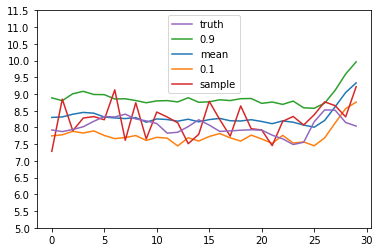

In [78]:
year = 1984 # “He who controls the past controls the future. He who controls the present controls the past.”

prediction_data = buildPredictionData(year, trainingSet)

result = predictor.predict(prediction_data).encode('utf-8')

plotSeries(result, 
           truth=True, 
           truth_data=testSet[str(year)][-prediction_length:], 
           truth_label='truth')

## Example: predict temperature for the next 'prediction_length' days

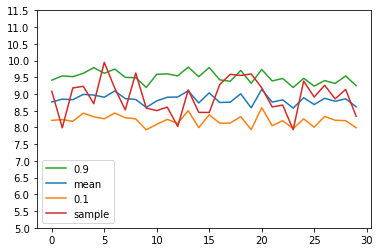

In [89]:
# Predict temperature for the next 'prediction_length' days of 2018
year = 2018
year_temps={}
year_temps[str(year)] = np.random.normal(9, 1.5, 90).tolist()

prediction_data = buildPredictionData(year, year_temps)
result = predictor.predict(prediction_data).encode('utf-8')
plotSeries(result)

## Clean up

In [90]:
print(job_name)
sm = boto3.client('sagemaker')
#sm.delete_endpoint(EndpointName=job_name)
#sm.delete_endpoint_config(EndpointConfigName=job_name)
#sm.delete_model(ModelName=job_name)

daily-temperature-2018-01-31-22-07-07-547
